# game.py

In [1]:
from abc import ABC, abstractmethod
from copy import deepcopy
from enum import Enum
import random
import numpy as np


class Move(Enum):
    '''
    Selects where you want to place the taken piece. The rest of the pieces are shifted
    '''

    TOP = 0
    BOTTOM = 1
    LEFT = 2
    RIGHT = 3


class Player(ABC):
    def __init__(self) -> None:
        '''You can change this for your player if you need to handle state/have memory'''
        pass

    @abstractmethod
    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:

        '''
        The game accepts coordinates of the type (X, Y). X goes from left to right, while Y goes from top to bottom, as in 2D graphics.
        Thus, the coordinates that this method returns shall be in the (X, Y) format.

        game: the Quixo game. You can use it to override the current game with yours, but everything is evaluated by the main game
        return values: this method shall return a tuple of X,Y positions and a move among TOP, BOTTOM, LEFT and RIGHT
        '''
        pass


class Game(object):
    def __init__(self) -> None:
        self._board = np.ones((5, 5), dtype=np.uint8) * -1
        self.current_player_idx = 1

    def get_board(self) -> np.ndarray:
        '''
        Returns the board
        '''
        return deepcopy(self._board)
        # return self._board.copy()

    def get_current_player(self) -> int:
        '''
        Returns the current player
        '''
        return deepcopy(self.current_player_idx)

    def print(self):
        '''Prints the board. -1 are neutral pieces, 0 are pieces of player 0, 1 pieces of player 1'''
        print(self._board)

    def clone(self):
        new_game = Game()
        # new_game._board = self._board.copy()
        new_game._board = deepcopy(self._board)
        new_game.current_player_idx = self.current_player_idx
        return new_game

    def check_winner(self) -> int:
        '''Check the winner. Returns the player ID of the winner if any, otherwise returns -1'''
        # for each row
        for x in range(self._board.shape[0]):
            # if a player has completed an entire row
            if self._board[x, 0] != -1 and all(self._board[x, :] == self._board[x, 0]):
                # return the relative id
                return self._board[x, 0]
        # for each column
        for y in range(self._board.shape[1]):
            # if a player has completed an entire column
            if self._board[0, y] != -1 and all(self._board[:, y] == self._board[0, y]):
                # return the relative id
                return self._board[0, y]
        # if a player has completed the principal diagonal
        if self._board[0, 0] != -1 and all(
            [self._board[x, x] for x in range(self._board.shape[0])] == self._board[0, 0]
        ):
            # return the relative id
            return self._board[0, 0]
        # if a player has completed the secondary diagonal
        if self._board[0, -1] != -1 and all(
            [self._board[x, -(x + 1)] for x in range(self._board.shape[0])] == self._board[0, -1]
        ):
            # return the relative id
            return self._board[0, -1]
        return -1

    def play(self, player1: Player, player2: Player) -> int:
        '''Play the game. Returns the winning player'''
        players = [player1, player2]
        winner = -1
        while winner < 0:
            self.current_player_idx += 1
            self.current_player_idx %= len(players)
            ok = False
            while not ok:
                from_pos, slide = players[self.current_player_idx].make_move(self)
                ok = self.move(from_pos, slide, self.current_player_idx)
            winner = self.check_winner()
        return winner

    def move(self, from_pos: tuple[int, int], slide: Move, player_id: int) -> bool:
        '''Perform a move'''
        if player_id > 2:
            return False

        prev_value = deepcopy(self._board[(from_pos[1], from_pos[0])])
        acceptable = self.__take((from_pos[1], from_pos[0]), player_id)
        if acceptable:
            acceptable = self.__slide((from_pos[1], from_pos[0]), slide)
            if not acceptable:
                self._board[(from_pos[1], from_pos[0])] = deepcopy(prev_value)
        return acceptable

    def __take(self, from_pos: tuple[int, int], player_id: int) -> bool:
        '''Take piece'''
        # acceptable only if in border
        acceptable: bool = (
            # check if it is in the first row
            (from_pos[0] == 0 and from_pos[1] < 5)
            # check if it is in the last row
            or (from_pos[0] == 4 and from_pos[1] < 5)
            # check if it is in the first column
            or (from_pos[1] == 0 and from_pos[0] < 5)
            # check if it is in the last column
            or (from_pos[1] == 4 and from_pos[0] < 5)
            # and check if the piece can be moved by the current player
        ) and (self._board[from_pos] < 0 or self._board[from_pos] == player_id)
        if acceptable:
            self._board[from_pos] = player_id
        return acceptable

    def __slide(self, from_pos: tuple[int, int], slide: Move) -> bool:
        '''Slide the other pieces'''
        # define the corners
        SIDES = [(0, 0), (0, 4), (4, 0), (4, 4)]
        # if the piece position is not in a corner
        if from_pos not in SIDES:
            # if it is at the TOP, it can be moved down, left or right
            acceptable_top: bool = from_pos[0] == 0 and (
                slide == Move.BOTTOM or slide == Move.LEFT or slide == Move.RIGHT
            )
            # if it is at the BOTTOM, it can be moved up, left or right
            acceptable_bottom: bool = from_pos[0] == 4 and (
                slide == Move.TOP or slide == Move.LEFT or slide == Move.RIGHT
            )
            # if it is on the LEFT, it can be moved up, down or right
            acceptable_left: bool = from_pos[1] == 0 and (
                slide == Move.BOTTOM or slide == Move.TOP or slide == Move.RIGHT
            )
            # if it is on the RIGHT, it can be moved up, down or left
            acceptable_right: bool = from_pos[1] == 4 and (
                slide == Move.BOTTOM or slide == Move.TOP or slide == Move.LEFT
            )
        # if the piece position is in a corner
        else:
            # if it is in the upper left corner, it can be moved to the right and down
            acceptable_top: bool = from_pos == (0, 0) and (slide == Move.BOTTOM or slide == Move.RIGHT)
            # if it is in the lower left corner, it can be moved to the right and up
            acceptable_left: bool = from_pos == (4, 0) and (slide == Move.TOP or slide == Move.RIGHT)
            # if it is in the upper right corner, it can be moved to the left and down
            acceptable_right: bool = from_pos == (0, 4) and (slide == Move.BOTTOM or slide == Move.LEFT)
            # if it is in the lower right corner, it can be moved to the left and up
            acceptable_bottom: bool = from_pos == (4, 4) and (slide == Move.TOP or slide == Move.LEFT)
        # check if the move is acceptable
        acceptable: bool = acceptable_top or acceptable_bottom or acceptable_left or acceptable_right
        # if it is
        if acceptable:
            # take the piece
            piece = self._board[from_pos]
            # if the player wants to slide it to the left
            if slide == Move.LEFT:
                # for each column starting from the column of the piece and moving to the left
                for i in range(from_pos[1], 0, -1):
                    # copy the value contained in the same row and the previous column
                    self._board[(from_pos[0], i)] = self._board[(from_pos[0], i - 1)]
                # move the piece to the left
                self._board[(from_pos[0], 0)] = piece
            # if the player wants to slide it to the right
            elif slide == Move.RIGHT:
                # for each column starting from the column of the piece and moving to the right
                for i in range(from_pos[1], self._board.shape[1] - 1, 1):
                    # copy the value contained in the same row and the following column
                    self._board[(from_pos[0], i)] = self._board[(from_pos[0], i + 1)]
                # move the piece to the right
                self._board[(from_pos[0], self._board.shape[1] - 1)] = piece
            # if the player wants to slide it upward
            elif slide == Move.TOP:
                # for each row starting from the row of the piece and going upward
                for i in range(from_pos[0], 0, -1):
                    # copy the value contained in the same column and the previous row
                    self._board[(i, from_pos[1])] = self._board[(i - 1, from_pos[1])]
                # move the piece up
                self._board[(0, from_pos[1])] = piece
            # if the player wants to slide it downward
            elif slide == Move.BOTTOM:
                # for each row starting from the row of the piece and going downward
                for i in range(from_pos[0], self._board.shape[0] - 1, 1):
                    # copy the value contained in the same column and the following row
                    self._board[(i, from_pos[1])] = self._board[(i + 1, from_pos[1])]
                # move the piece down
                self._board[(self._board.shape[0] - 1, from_pos[1])] = piece
        return acceptable

    def get_available_actions(self):
        '''Return a list of all possible actions'''
        board = self.get_board()
        actions = []
        size = board.shape[0]
        for x in range(size):
            for y in range(size):
                if x == 0 or x == size - 1 or y == 0 or y == size - 1:
                    if board[x, y] == -1 or board[x, y] == self.get_current_player():
                        if x == 0:
                            actions.append(((x, y), Move.BOTTOM))
                        if x == size - 1:
                            actions.append(((x, y), Move.TOP))
                        if y == 0:
                            actions.append(((x, y), Move.RIGHT))
                        if y == size - 1:
                            actions.append(((x, y), Move.LEFT))
        return actions

    def get_non_quiescent_actions(self):
        '''Return a list of all possible non-quiescent actions as a subset of the available ones'''
        board = self.get_board()
        actions = []
        size = board.shape[0]
        for x in range(size):
            for y in range(size):
                if x == 0 or x == size - 1 or y == 0 or y == size - 1:
                    if board[x, y] == -1 or board[x, y] == self.get_current_player():
                        if x == 0:
                            actions.append(((x, y), Move.BOTTOM))
                        if x == size - 1:
                            actions.append(((x, y), Move.TOP))
                        if y == 0:
                            actions.append(((x, y), Move.RIGHT))
                        if y == size - 1:
                            actions.append(((x, y), Move.LEFT))
        non_quiescent_actions = []
        for action in actions:
            from_pos, slide = action
            if self.__move_to_empty_square(from_pos, slide) or self.__block_opponent_winning_line(from_pos, slide) or self.__create_potential_winning_line(from_pos, slide):
                non_quiescent_actions.append(action)
        return non_quiescent_actions

    def __move_to_empty_square(self, from_pos: tuple[int, int], slide: Move) -> bool:
        '''Move a cube to an empty square on the board'''
        to_pos = (from_pos[0], from_pos[1] - 1) if slide == Move.LEFT else (from_pos[0], from_pos[1] + 1) if slide == Move.RIGHT else (from_pos[0] - 1, from_pos[1]) if slide == Move.TOP else (from_pos[0] + 1, from_pos[1])
        if self._board[to_pos] == -1:
            self._board[to_pos] = self._board[from_pos]
            self._board[from_pos] = -1
            return True
        return False

    def __block_opponent_winning_line(self, from_pos: tuple[int, int], slide: Move) -> bool:
        '''Move a cube to a square that blocks an opponent's potential winning line'''
        to_pos = (from_pos[0], from_pos[1] - 1) if slide in [Move.LEFT, Move.RIGHT] else (from_pos[0], from_pos[1] + slide.value)
        if 0 <= to_pos[0] < self._board.shape[0] and 0 <= to_pos[1] < self._board.shape[1]:
            if self._board[to_pos] == ((self.get_current_player() + 1) % 2):
                self._board[to_pos] = self._board[from_pos]
                self._board[from_pos] = -1
                return True
        return False

    def __create_potential_winning_line(self, from_pos: tuple[int, int], slide: Move) -> bool:
        '''Move a cube to a square that creates a potential winning line for the player'''
        to_pos = (from_pos[0], from_pos[1] - 1) if slide in [Move.LEFT, Move.RIGHT] else (from_pos[0], from_pos[1] + slide.value)
        if 0 <= to_pos[0] < self._board.shape[0] and 0 <= to_pos[1] < self._board.shape[1]:
            if self._board[to_pos] == -1:
                self._board[to_pos] = self._board[from_pos]
                self._board[from_pos] = -1
                return True
        return False

# heuristic.py

In [2]:
import random


def heuristic(game: Game) -> int:

    board = game.get_board()

    score = 0

    for x in range(board.shape[0]):
        for y in range(board.shape[1]):
            if board[x, y]!= -1:  # for each piece on the board
                if board[x, y] == game.get_current_player():
                    score += 1
                else:
                    score -= 1

    for action in game.get_non_quiescent_actions():
        from_pos, slide = action
        to_pos = (from_pos[0], from_pos[1] - 1) if slide == Move.LEFT else (from_pos[0], from_pos[1] + 1) if slide == Move.RIGHT else (from_pos[0] - 1, from_pos[1]) if slide == Move.TOP else (from_pos[0] + 1, from_pos[1])
        if 0 <= to_pos[0] < board.shape[0] and 0 <= to_pos[1] < board.shape[1] and board[to_pos] == -1:
            score += 1
        elif 0 <= to_pos[0] < board.shape[0] and 0 <= to_pos[1] < board.shape[1] and board[to_pos] == ((game.get_current_player() + 1) % 2):
            score -= 1
        # The score is increased by 1 for each potential winning line that the current player can create, and decreased by 1 for each potential winning line that the opponent can create.
    return score


# RandomPlayer

In [3]:
class RandomPlayer(Player):
    def __init__(self,player_symbol):
        super().__init__()
        self.player_symbol=player_symbol

    def make_move(self, game: "Game") -> tuple[tuple[int, int], Move]:
        from_pos = (random.randint(0, 4), random.randint(0, 4))
        move = random.choice([Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT])
        return from_pos, move

# CleverRandomPlayer

In [4]:
class CleverRandomPlayer(Player):
    def __init__(self,player_symbol):
        super().__init__()
        self.player_symbol=player_symbol

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:
        valid_move = False
        while not valid_move:
            from_pos = (random.randint(0, 4), random.randint(0, 4))
            move = random.choice([Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT])
            valid_move = game.move(from_pos, move, self.player_symbol)
        return from_pos, move

MinimaxPlayer

In [5]:
import typing


class MinimaxPlayer(Player):
    # NB: a depth of -1 indicates that search will continue until terminal state or quiet
    def __init__(self, player_symbol, heuristic: typing.Callable[[Game], int], max_depth: int = -1, quiescence_max_depth: int = -1):
                    # the input of heuristic function is the State, the output is an int
        super().__init__()
        self.player_symbol = player_symbol
        self.heuristic = heuristic
        self.max_depth = max_depth
        self.quiescence_max_depth = quiescence_max_depth

    def minimax(self, current_state: Game, depth: int, max_node: bool) -> int:

        if current_state.check_winner != -1 or depth is self.max_depth:
            return self.heuristic(current_state)

        elif max_node:
            best_val = -100000
            actions = current_state.get_available_actions()
            for action in actions:
                current_state.move(action[0], action[1], self.player_symbol)
                value = self.minimax(current_state, depth + 1, False)
                best_val = max(best_val, value)
            return best_val

        else:
            best_val = 100000
            actions = current_state.get_available_actions()
            for action in actions:
                current_state.move(action[0], action[1], self.player_symbol)
                value = self.minimax(current_state, depth + 1, True)
                best_val = min(best_val, value)
            return best_val

    def alpha_beta_solve(self, current_state: Game, depth: int, max_node: bool, alpha: int, beta: int) -> int:
        if current_state.check_winner()!= -1:
            return self.heuristic(current_state)
        elif depth is self.max_depth:
            return self.quiescence_search(current_state, 5, max_node, alpha, beta)

        elif max_node:
            best_val = -100000
            actions = current_state.get_available_actions()
            for action in actions:
                current_state.move(action[0], action[1], self.player_symbol)
                value = self.alpha_beta_solve(current_state, depth + 1, False, alpha, beta)
                best_val = max(best_val, value)
                if best_val >= beta:
                    return best_val
                alpha = max(best_val, alpha)
                if alpha >= beta:
                    break
            return best_val

        else:
            best_val = 100000
            actions = current_state.get_available_actions()
            for action in actions:
                current_state.move(action[0], action[1], self.player_symbol)
                value = self.alpha_beta_solve(current_state, depth + 1, True, alpha, beta)
                best_val = min(best_val, value)
                if best_val <= alpha:
                    return best_val
                beta = min(best_val, beta)
                if alpha >= beta:
                    break
            return best_val

    def quiescence_search(self, current_state: Game, depth: int, max_node: bool, alpha: int, beta: int) -> int:
        if current_state.check_winner()!= -1 or depth is self.quiescence_max_depth:
            return self.heuristic(current_state)
        non_quiescent_actions = current_state.get_non_quiescent_actions()

        if not non_quiescent_actions:
            # quiet state
            return self.heuristic(current_state)

        elif max_node:
            best_val = -100000
            stand_pat = self.heuristic(current_state)
            if stand_pat >= beta:
                return stand_pat
            if alpha < stand_pat:
                alpha = stand_pat

            for action in non_quiescent_actions:
                current_state.move(action[0], action[1], self.player_symbol)
                value = self.quiescence_search(current_state, depth + 1, False, alpha, beta)
                best_val = max(best_val, value)
                if best_val >= beta:
                    return best_val
                alpha = max(best_val, alpha)
            return best_val

        else:
            stand_pat = self.heuristic(current_state)
            if stand_pat <= alpha:
                return stand_pat
            if stand_pat < beta:
                beta = stand_pat

            best_val = 100000
            for action in non_quiescent_actions:
                current_state.move(action[0], action[1], self.player_symbol)
                value = self.quiescence_search(current_state, depth + 1, True, alpha, beta)
                best_val = min(best_val, value)
                if best_val <= alpha:
                    return best_val
                beta = min(best_val, beta)
            return best_val

    def make_move(self, game) -> tuple[tuple[int, int], Move]:
        action = self.choose_action(game, False)
        return action

    def choose_action(self, current_state: Game, maximizing_player: bool) -> Move:
        if maximizing_player:
            def func(x, y):
                return x > y
        else:
            def func(x, y):
                return x < y

        actions = current_state.get_available_actions()
        assert (actions is not None)

        best_value = -1000000 if maximizing_player else 1000000

        for action in actions:
            current_state.move(action[0], action[1], self.player_symbol)
            # action_value = self.alpha_beta_solve(current_state, 1, False, -10000000, 10000000)
            action_value = self.minimax(current_state, 1, not maximizing_player)

            if func(action_value, best_value):
                best_value = action_value
                best_action = action
        return best_action

#QLearningPlayer

In [6]:
import numpy as np
from collections import defaultdict, deque
import pickle

class QLearningPlayer(Player):
    def __init__(self, player_symbol, epsilon, epsilon_decay, epsilon_min, alpha, gamma, replay_buffer_size=10000):
        super().__init__()
        self.player_symbol = player_symbol
        self.q_values = {}
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.alpha = alpha
        self.gamma = gamma
        self.replay_buffer = deque(maxlen=replay_buffer_size)

    def do_it_random(self, game):
        state_key = tuple(map(tuple, game.get_board()))
        available_actions = self.get_available_actions(game.get_board())
        action = random.choice(available_actions)
        self.q_values[(state_key, action)] = self.epsilon
        return action

    def get_q_value(self, state, action):
        state_key = tuple(map(tuple, state))
        return self.q_values.get((state_key, action), 0.0)

    def make_move(self, game):
        state_key = tuple(map(tuple, game.get_board()))
        available_actions = self.get_available_actions(game.get_board())

        if random.random() <= self.epsilon:
            best_move = self.do_it_random(game)
        else:
            q_values = [self.get_q_value(state_key, action) for action in available_actions]
            max_q_value = max(q_values)
            best_moves = [action for action, q_value in zip(available_actions, q_values) if q_value == max_q_value]

            if not best_moves:
                best_move = random.choice(available_actions)
            else:
                best_move = random.choice(best_moves)

        return best_move

    def update_q_value(self, state, action, reward, next_state):
        state_key = tuple(map(tuple, state))
        next_state_key = tuple(map(tuple, next_state))
        next_max_q = max([self.get_q_value(next_state_key, next_action) for next_action in self.get_available_actions(next_state)], default=0.0)
        self.q_values[(state_key, action)] = (1 - self.alpha) * self.get_q_value(state_key, action) + self.alpha * (reward + self.gamma * next_max_q)

    def get_available_actions(self, board):
        actions = []
        size = board.shape[0]
        for x in range(size):
            for y in range(size):
                if x == 0 or x == size - 1 or y == 0 or y == size - 1:
                    if board[x, y] == -1 or board[x, y] == self.player_symbol:
                        if x == 0:
                            actions.append(((x, y), Move.BOTTOM))
                        if x == size - 1:
                            actions.append(((x, y), Move.TOP))
                        if y == 0:
                            actions.append(((x, y), Move.RIGHT))
                        if y == size - 1:
                            actions.append(((x, y), Move.LEFT))
        return actions

    def feed_reward(self, state, reward, action):
        state_key = tuple(map(tuple, state))
        if (state_key, action) in self.q_values:
            self.q_values[(state_key, action)] += self.alpha * (reward + self.gamma * self.q_values[(state_key, action)] - self.q_values[(state_key, action)])
            r = self.q_values[(state_key, action)]
        else:
            self.q_values[(state_key, action)] = -self.epsilon
            r = -self.epsilon
        return r

    def save_q_table(self, file_path):
        with open(file_path, 'wb') as file:
            pickle.dump(self.q_values, file)

    def load_q_table(self, file_path):
        with open(file_path, 'rb') as file:
            self.q_values = pickle.load(file)

    def store_experience(self, state, action, reward, next_state):
        self.replay_buffer.append((state, action, reward, next_state))

    def replay_experiences(self, batch_size=64):
        if len(self.replay_buffer) < batch_size:
            return
        batch = random.sample(self.replay_buffer, batch_size)
        for state, action, reward, next_state in batch:
            self.update_q_value(state, action, reward, next_state)

# MonteCarloPlayer

In [15]:
import math

class MonteCarloPlayer(Player):
    def __init__(self, player_symbol):
        super().__init__()
        self.player_symbol = player_symbol

    # UCB = average_score + C * sqrt(ln(total_simulations) / simulations)
    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:
        num_simulations = 50
        num_selected_moves = min(len(game.get_available_actions()), 40)
        best_move = None
        best_score = -1000000

        total_simulations = sum(num_simulations for _ in game.get_available_actions())

        for pos, slide in random.sample(game.get_available_actions(), num_selected_moves):
            simulations = num_simulations
            average_score = heuristic(game)
            C = 1  # Trade-off between exploration and exploitation
            ucb_score = average_score + C * math.sqrt(math.log(total_simulations) / simulations)

            total_score = ucb_score
            for _ in range(num_simulations):
                # cloned_game = deepcopy(game)
                cloned_game = game
                cloned_game.move(pos, slide, game.get_current_player())

                while cloned_game.check_winner() == -1:
                    valid_move = False
                    while not valid_move:
                        from_pos = (random.randint(0, 4), random.randint(0, 4))
                        move = random.choice([Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT])
                        valid_move = game.move(from_pos, move, self.player_symbol)

                if cloned_game.check_winner() == self.player_symbol:
                    total_score += 1
                else:
                    total_score -= 1

            if ucb_score > best_score:
                best_score = ucb_score
                best_move = (pos, slide)

        return best_move


# main.py

playing games ...


Gaming Progress: 100%|██████████| 100/100 [00:01<00:00, 96.61it/s]


Player 1 RandomPlayer symbol 0 win percentage: 48.0%
Player 2 RandomPlayer symbol 1 win percentage: 52.0%


Gaming Progress: 100%|██████████| 100/100 [00:00<00:00, 202.13it/s]


Player 1 RandomPlayer symbol 0 win percentage: 22.0%
Player 2 CleverRandomPlayer symbol 1 win percentage: 78.0%


Gaming Progress: 100%|██████████| 100/100 [00:02<00:00, 37.66it/s]


Player 1 RandomPlayer symbol 0 win percentage: 16.0%
Player 2 MinimaxPlayer symbol 1 win percentage: 84.0%


Gaming Progress: 100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


Player 1 RandomPlayer symbol 0 win percentage: 10.0%
Player 2 MonteCarloPlayer symbol 1 win percentage: 90.0%


Gaming Progress: 100%|██████████| 100/100 [00:00<00:00, 240.94it/s]


Player 1 CleverRandomPlayer symbol 0 win percentage: 89.0%
Player 2 RandomPlayer symbol 1 win percentage: 11.0%


Gaming Progress: 100%|██████████| 100/100 [00:00<00:00, 248.11it/s]


Player 1 CleverRandomPlayer symbol 0 win percentage: 57.99999999999999%
Player 2 CleverRandomPlayer symbol 1 win percentage: 42.0%


Gaming Progress: 100%|██████████| 100/100 [00:01<00:00, 75.07it/s]


Player 1 CleverRandomPlayer symbol 0 win percentage: 14.000000000000002%
Player 2 MinimaxPlayer symbol 1 win percentage: 86.0%


Gaming Progress: 100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


Player 1 CleverRandomPlayer symbol 0 win percentage: 10.0%
Player 2 MonteCarloPlayer symbol 1 win percentage: 90.0%


Gaming Progress: 100%|██████████| 100/100 [00:03<00:00, 29.45it/s]


Player 1 MinimaxPlayer symbol 0 win percentage: 74.0%
Player 2 RandomPlayer symbol 1 win percentage: 26.0%


Gaming Progress: 100%|██████████| 100/100 [00:01<00:00, 91.30it/s]


Player 1 MinimaxPlayer symbol 0 win percentage: 94.0%
Player 2 CleverRandomPlayer symbol 1 win percentage: 6.0%


Gaming Progress: 100%|██████████| 100/100 [00:01<00:00, 50.78it/s]


Player 1 MinimaxPlayer symbol 0 win percentage: 100.0%
Player 2 MinimaxPlayer symbol 1 win percentage: 0.0%


Gaming Progress: 100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


Player 1 MinimaxPlayer symbol 0 win percentage: 98.0%
Player 2 MonteCarloPlayer symbol 1 win percentage: 2.0%


Gaming Progress: 100%|██████████| 100/100 [00:06<00:00, 14.67it/s]


Player 1 MonteCarloPlayer symbol 0 win percentage: 93.0%
Player 2 RandomPlayer symbol 1 win percentage: 7.000000000000001%


Gaming Progress: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s]


Player 1 MonteCarloPlayer symbol 0 win percentage: 94.0%
Player 2 CleverRandomPlayer symbol 1 win percentage: 6.0%


Gaming Progress: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


Player 1 MonteCarloPlayer symbol 0 win percentage: 96.0%
Player 2 MinimaxPlayer symbol 1 win percentage: 4.0%


Gaming Progress: 100%|██████████| 100/100 [00:08<00:00, 11.21it/s]


Player 1 MonteCarloPlayer symbol 0 win percentage: 89.0%
Player 2 MonteCarloPlayer symbol 1 win percentage: 11.0%




Training Progress: 100%|██████████| 100/100 [02:41<00:00,  1.61s/it]


Player 1 QLearningPlayer symbol 0 win percentage: 51.0%
Player 2 RandomPlayer symbol 1 win percentage: 49.0%


Testing Progress: 100%|██████████| 50/50 [00:01<00:00, 32.73it/s]


Player 1 QLearningPlayer symbol 0 win percentage: 10.0%
Player 2 RandomPlayer symbol 1 win percentage: 90.0%


Training Progress: 100%|██████████| 100/100 [00:10<00:00,  9.85it/s]


Player 1 QLearningPlayer symbol 0 win percentage: 6.0%
Player 2 CleverRandomPlayer symbol 1 win percentage: 94.0%


Testing Progress: 100%|██████████| 50/50 [00:00<00:00, 79.38it/s]


Player 1 QLearningPlayer symbol 0 win percentage: 12.0%
Player 2 CleverRandomPlayer symbol 1 win percentage: 88.0%


Training Progress: 100%|██████████| 100/100 [00:02<00:00, 43.64it/s]


Player 1 QLearningPlayer symbol 0 win percentage: 3.0%
Player 2 MinimaxPlayer symbol 1 win percentage: 97.0%


Testing Progress: 100%|██████████| 50/50 [00:00<00:00, 80.40it/s]


Player 1 QLearningPlayer symbol 0 win percentage: 2.0%
Player 2 MinimaxPlayer symbol 1 win percentage: 98.0%


Training Progress: 100%|██████████| 100/100 [00:05<00:00, 18.84it/s]


Player 1 QLearningPlayer symbol 0 win percentage: 6.0%
Player 2 MonteCarloPlayer symbol 1 win percentage: 94.0%


Testing Progress: 100%|██████████| 50/50 [00:04<00:00, 10.58it/s]


Player 1 QLearningPlayer symbol 0 win percentage: 4.0%
Player 2 MonteCarloPlayer symbol 1 win percentage: 96.0%




Training Progress: 100%|██████████| 100/100 [03:22<00:00,  2.03s/it]


Player 1 RandomPlayer symbol 0 win percentage: 56.00000000000001%
Player 2 QLearningPlayer symbol 1 win percentage: 44.0%


Testing Progress: 100%|██████████| 50/50 [00:01<00:00, 49.77it/s]


Player 1 RandomPlayer symbol 0 win percentage: 88.0%
Player 2 QLearningPlayer symbol 1 win percentage: 12.0%


Training Progress: 100%|██████████| 100/100 [00:10<00:00,  9.10it/s]


Player 1 CleverRandomPlayer symbol 0 win percentage: 89.0%
Player 2 QLearningPlayer symbol 1 win percentage: 11.0%


Testing Progress: 100%|██████████| 50/50 [00:00<00:00, 143.11it/s]


Player 1 CleverRandomPlayer symbol 0 win percentage: 84.0%
Player 2 QLearningPlayer symbol 1 win percentage: 16.0%


Training Progress: 100%|██████████| 100/100 [00:02<00:00, 43.23it/s]


Player 1 MinimaxPlayer symbol 0 win percentage: 97.0%
Player 2 QLearningPlayer symbol 1 win percentage: 3.0%


Testing Progress: 100%|██████████| 50/50 [00:00<00:00, 57.72it/s]


Player 1 MinimaxPlayer symbol 0 win percentage: 94.0%
Player 2 QLearningPlayer symbol 1 win percentage: 6.0%


Training Progress: 100%|██████████| 100/100 [00:05<00:00, 17.81it/s]


Player 1 MonteCarloPlayer symbol 0 win percentage: 94.0%
Player 2 QLearningPlayer symbol 1 win percentage: 6.0%


Testing Progress: 100%|██████████| 50/50 [00:04<00:00, 10.09it/s]


Player 1 MonteCarloPlayer symbol 0 win percentage: 98.0%
Player 2 QLearningPlayer symbol 1 win percentage: 2.0%


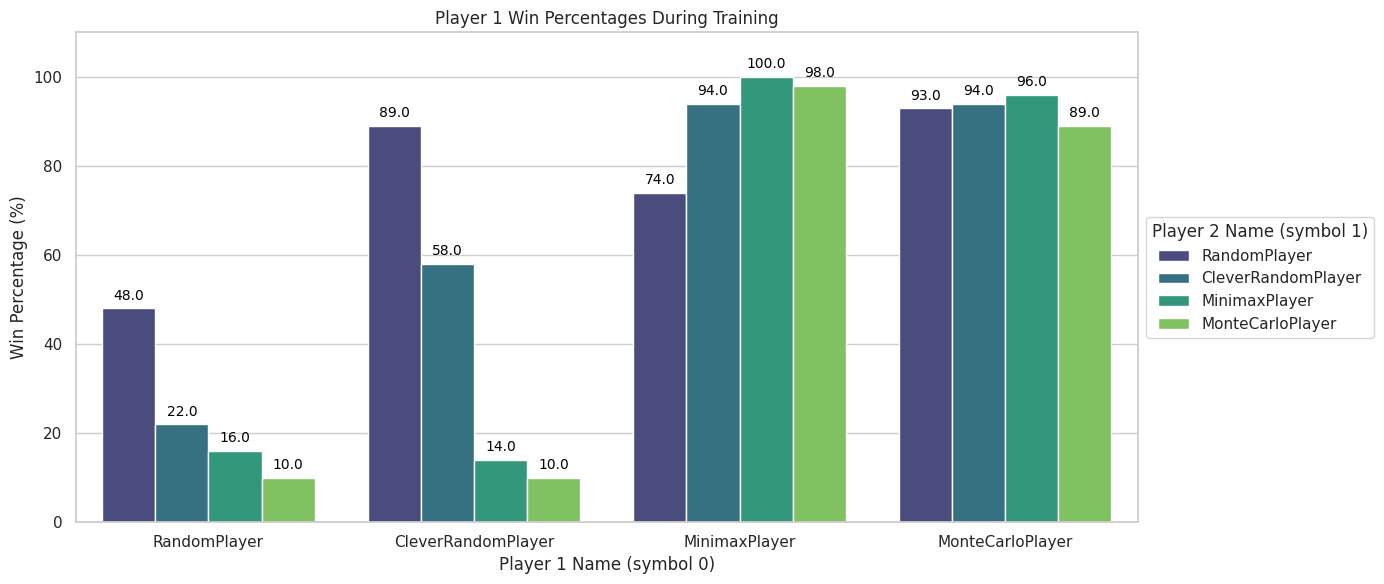

<Figure size 640x480 with 0 Axes>

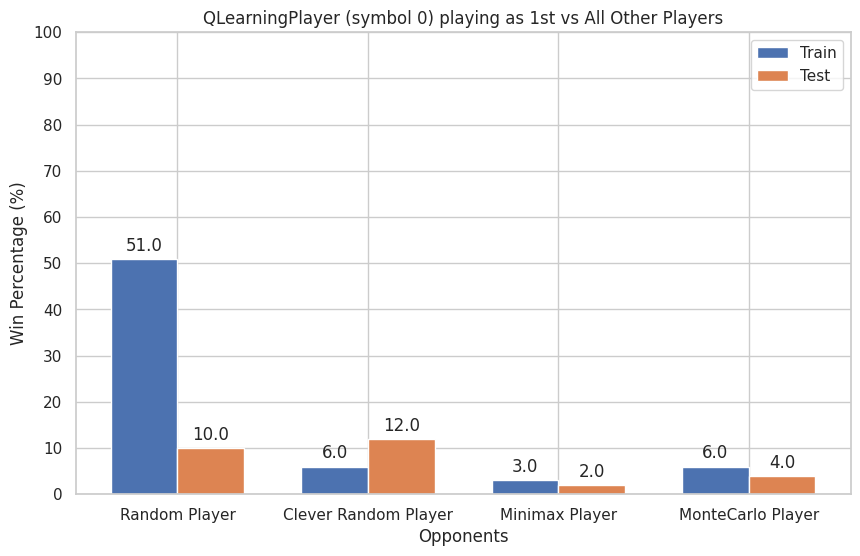

<Figure size 640x480 with 0 Axes>

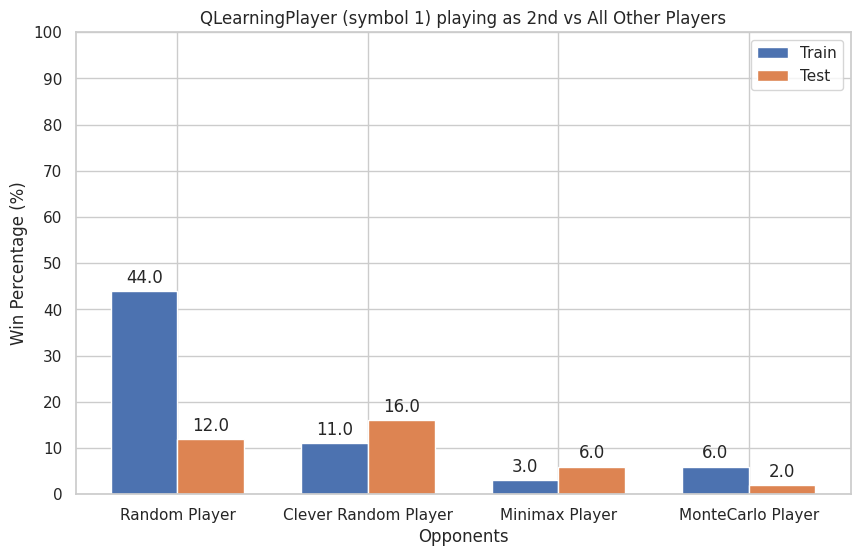

<Figure size 640x480 with 0 Axes>

In [16]:
from collections import defaultdict
import random
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def game(player1, player2):
    quixo_game = Game()
    winner = quixo_game.play(player1, player2)
    return winner

def give_reward(state, player1, player2, action, game):
    if isinstance(player1, QLearningPlayer):
        if game.check_winner() == player1.player_symbol:
            fr = player1.feed_reward(state, 1, action)
        elif game.check_winner() == player2.player_symbol:
            fr = player1.feed_reward(state, -1, action)
        else:
            fr = player1.feed_reward(state, -0.01, action)
    elif isinstance(player2, QLearningPlayer):
        if game.check_winner() == player1.player_symbol:
            fr = player2.feed_reward(state, -1, action)
        elif game.check_winner() == player2.player_symbol:
            fr = player2.feed_reward(state, 1, action)
        else:
            fr = player2.feed_reward(state, -0.01, action)
    else:
        fr = 0
    return fr

def train(player1, player2, matches, q_table_file):
    wins = {player1: 0, player2: 0}

    for _ in tqdm(range(matches), desc='Training Progress'):
        quixo_game = Game()
        trajectory = []
        winner = -1

        while winner < 0:
            state = quixo_game.get_board()
            current_player = quixo_game.get_current_player()
            player = player1 if current_player == 1 else player2
            action = player.make_move(quixo_game)
            quixo_game.move(action[0], action[1], current_player)
            trajectory.append((state, action))
            winner = quixo_game.check_winner()

            reward = give_reward(trajectory[-1][0], player1, player2, action, quixo_game)
            for (state, action) in trajectory:
                if isinstance(player1, QLearningPlayer):
                    player1.update_q_value(state, action, reward, trajectory[-1][0])
                elif isinstance(player2, QLearningPlayer):
                    player2.update_q_value(state, action, reward, trajectory[-1][0])

            quixo_game.current_player_idx = 1 if quixo_game.current_player_idx == 0 else 0

        if winner == player1.player_symbol:
            wins[player1] += 1
        elif winner == player2.player_symbol:
            wins[player2] += 1
        player1.player_symbol, player2.player_symbol = player2.player_symbol, player1.player_symbol

    win_percentage_player1 = (wins[player1] / matches) * 100
    win_percentage_player2 = (wins[player2] / matches) * 100
    print(f'Player 1 {player1.__class__.__name__} symbol {player1.player_symbol} win percentage: {win_percentage_player1}%')
    print(f'Player 2 {player2.__class__.__name__} symbol {player2.player_symbol} win percentage: {win_percentage_player2}%')

    if isinstance(player1, QLearningPlayer):
        player1.save_q_table(q_table_file)
    if isinstance(player2, QLearningPlayer):
        player2.save_q_table(q_table_file)

    return player1.__class__.__name__, player1.player_symbol, win_percentage_player1, player2.__class__.__name__, player2.player_symbol, win_percentage_player2

def test(player1, player2, matches, q_table_file):
    if isinstance(player1, QLearningPlayer) and q_table_file:
        player1.load_q_table(q_table_file)
    if isinstance(player2, QLearningPlayer) and q_table_file:
        player2.load_q_table(q_table_file)

    wins = {player1: 0, player2: 0}
    for _ in tqdm(range(matches), desc='Testing Progress'):

        quixo_game = Game()
        winner = -1
        while winner < 0:
            state = quixo_game._board
            current_player = quixo_game.get_current_player()
            player = player1 if current_player == 1 else player2
            action = player.make_move(quixo_game)
            quixo_game.move(action[0], action[1], current_player)
            winner = quixo_game.check_winner()
            quixo_game.current_player_idx = 1 if quixo_game.current_player_idx == 0 else 0

        if winner == player1.player_symbol:
            wins[player1] += 1
        elif winner == player2.player_symbol:
            wins[player2] += 1

    win_percentage_player1 = (wins[player1] / matches) * 100
    win_percentage_player2 = (wins[player2] / matches) * 100
    print(f'Player 1 {player1.__class__.__name__} symbol {player1.player_symbol} win percentage: {win_percentage_player1}%')
    print(f'Player 2 {player2.__class__.__name__} symbol {player2.player_symbol} win percentage: {win_percentage_player2}%')
    return player1.__class__.__name__, player1.player_symbol, win_percentage_player1, player2.__class__.__name__, player2.player_symbol, win_percentage_player2


def play_game(player1, player2, matches):
    wins = {player1: 0, player2: 0}
    for _ in tqdm(range(matches), desc='Gaming Progress'):

        quixo_game = Game()
        winner = -1
        while winner < 0:
            state = quixo_game._board
            current_player = quixo_game.get_current_player()
            player = player1 if current_player == 1 else player2
            action = player.make_move(quixo_game)
            quixo_game.move(action[0], action[1], current_player)
            winner = quixo_game.check_winner()
            quixo_game.current_player_idx = 1 if quixo_game.current_player_idx == 0 else 0

        if winner == player1.player_symbol:
            wins[player1] += 1
        elif winner == player2.player_symbol:
            wins[player2] += 1

    win_percentage_player1 = (wins[player1] / matches) * 100
    win_percentage_player2 = (wins[player2] / matches) * 100
    print(f'Player 1 {player1.__class__.__name__} symbol {player1.player_symbol} win percentage: {win_percentage_player1}%')
    print(f'Player 2 {player2.__class__.__name__} symbol {player2.player_symbol} win percentage: {win_percentage_player2}%')
    return player1.__class__.__name__, player1.player_symbol, win_percentage_player1, player2.__class__.__name__, player2.player_symbol, win_percentage_player2

def plot(df):
    plt.figure(figsize=(14, 6))
    sns.set(style="whitegrid")
    barplot = sns.barplot(x='Player 1 Name', y='Player 1 Win Percentage', hue='Player 2 Name', data=df, palette='viridis')
    plt.title('Player 1 Win Percentages During Training')
    plt.ylim(0, 110)
    plt.ylabel('Win Percentage (%)')
    plt.xlabel('Player 1 Name (symbol 0)')
    plt.legend(title='Player 2 Name (symbol 1)', loc='center left', bbox_to_anchor=(1, 0.5))
    for p in barplot.patches:
        if p.get_height() > 0:
            barplot.annotate(format(p.get_height(), '.1f'),
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha = 'center', va = 'center',
                            xytext = (0, 9),
                            textcoords = 'offset points',
                            fontsize=10, color='black')
    plt.tight_layout()
    plt.show()
    plt.savefig("res.png")

def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate('{}'.format(round(height, 2)),
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

def plot_q(dftrain, dftest):
    train_results = dftrain[dftrain['Player 1 Name'] == 'QLearningPlayer']
    test_results = dftest[dftest['Player 1 Name'] == 'QLearningPlayer']

    plot_data = {
        'Opponent': ['Random Player', 'Clever Random Player', 'Minimax Player', 'MonteCarlo Player'],
        'Train': list(train_results['Player 1 Win Percentage']),
        'Test': list(test_results['Player 1 Win Percentage'])
    }

    plot_df = pd.DataFrame(plot_data)

    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = range(len(plot_df))

    bars1 = plt.bar(index, plot_df['Train'], bar_width, label='Train')
    bars2 = plt.bar([i + bar_width for i in index], plot_df['Test'], bar_width, label='Test')

    plt.xlabel('Opponents')
    plt.ylabel('Win Percentage (%)')
    plt.title('QLearningPlayer (symbol 0) playing as 1st vs All Other Players')
    plt.xticks([i + bar_width / 2 for i in index], plot_df['Opponent'])
    plt.legend()

    plt.yticks(np.arange(0, 101, 10))

    annotate_bars(bars1)
    annotate_bars(bars2)

    plt.show()
    plt.savefig("res_q.png")

def plot_q2(dftrain, dftest):
    train_results = dftrain[dftrain['Player 2 Name'] == 'QLearningPlayer']
    test_results = dftest[dftest['Player 2 Name'] == 'QLearningPlayer']

    plot_data = {
        'Opponent': ['Random Player', 'Clever Random Player', 'Minimax Player', 'MonteCarlo Player'],
        'Train': list(train_results['Player 2 Win Percentage']),
        'Test': list(test_results['Player 2 Win Percentage'])
    }

    plot_df = pd.DataFrame(plot_data)

    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = range(len(plot_df))

    bars1 = plt.bar(index, plot_df['Train'], bar_width, label='Train')
    bars2 = plt.bar([i + bar_width for i in index], plot_df['Test'], bar_width, label='Test')

    plt.xlabel('Opponents')
    plt.ylabel('Win Percentage (%)')
    plt.title('QLearningPlayer (symbol 1) playing as 2nd vs All Other Players')
    plt.xticks([i + bar_width / 2 for i in index], plot_df['Opponent'])
    plt.legend()

    plt.yticks(np.arange(0, 101, 10))

    annotate_bars(bars1)
    annotate_bars(bars2)

    plt.show()
    plt.savefig("res_q.png")

if __name__ == "__main__":
    results = []
    results2 = []
    game_results = []
    tresults = []
    tresults2 = []
    players1 = [RandomPlayer(player_symbol=0), CleverRandomPlayer(player_symbol=0), MinimaxPlayer(player_symbol=0, heuristic=heuristic), MonteCarloPlayer(player_symbol=0)]
    players2 = [RandomPlayer(player_symbol=1), CleverRandomPlayer(player_symbol=1), MinimaxPlayer(player_symbol=1, heuristic=heuristic), MonteCarloPlayer(player_symbol=1)]

    print("playing games ...")
    for player1_ in players1:
        for player2_ in players2:
            # if player1_.__class__.__name__ != player2_.__class__.__name__:
                player1_name, player1_symbol, win_percentage_player1, player2_name, player2_symbol, win_percentage_player2 = play_game(player1_, player2_, matches=100)
                game_results.append({
                    'Player 1 Name': player1_name,
                    'Player 1 Symbol': player1_symbol,
                    'Player 1 Win Percentage': win_percentage_player1,
                    'Player 2 Name': player2_name,
                    'Player 2 Symbol': player2_symbol,
                    'Player 2 Win Percentage': win_percentage_player2
                })
    df_res = pd.DataFrame(game_results)

    print("\n")
    player1 =  QLearningPlayer(player_symbol=0, epsilon=0.1, epsilon_decay=0.95, epsilon_min=0.01, alpha=0.2, gamma=0.9)
    for player2 in players2:
        if player1.__class__.__name__ != player2.__class__.__name__:
            player1_name, player1_symbol, win_percentage_player1, player2_name, player2_symbol, win_percentage_player2 = train(player1, player2, matches=100, q_table_file='q_table.pkl')
            test_player1_name, test_player1_symbol, test_win_percentage_player1, test_player2_name, test_player2_symbol, test_win_percentage_player2 = test(player1, player2, matches=50, q_table_file='q_table.pkl')
            results.append({
                'Player 1 Name': player1_name,
                'Player 1 Symbol': player1_symbol,
                'Player 1 Win Percentage': win_percentage_player1,
                'Player 2 Name': player2_name,
                'Player 2 Symbol': player2_symbol,
                'Player 2 Win Percentage': win_percentage_player2
            })
            tresults.append({
                'Player 1 Name': test_player1_name,
                'Player 1 Symbol': test_player1_symbol,
                'Player 1 Win Percentage': test_win_percentage_player1,
                'Player 2 Name': test_player2_name,
                'Player 2 Symbol': test_player2_symbol,
                'Player 2 Win Percentage': test_win_percentage_player2
            })

    dftrain = pd.DataFrame(results)
    dftest = pd.DataFrame(tresults)

    print("\n")
    player_2 =  QLearningPlayer(player_symbol=1, epsilon=0.1, epsilon_decay=0.95, epsilon_min=0.01, alpha=0.2, gamma=0.9)
    for player_1 in players1:
        if player1.__class__.__name__ != player2.__class__.__name__:
            player1_name, player1_symbol, win_percentage_player1, player2_name, player2_symbol, win_percentage_player2 = train(player_1, player_2, matches=100, q_table_file='q2_table.pkl')
            test_player1_name, test_player1_symbol, test_win_percentage_player1, test_player2_name, test_player2_symbol, test_win_percentage_player2 = test(player_1, player_2, matches=50, q_table_file='q2_table.pkl')
            results2.append({
                'Player 1 Name': player1_name,
                'Player 1 Symbol': player1_symbol,
                'Player 1 Win Percentage': win_percentage_player1,
                'Player 2 Name': player2_name,
                'Player 2 Symbol': player2_symbol,
                'Player 2 Win Percentage': win_percentage_player2
            })
            tresults2.append({
                'Player 1 Name': test_player1_name,
                'Player 1 Symbol': test_player1_symbol,
                'Player 1 Win Percentage': test_win_percentage_player1,
                'Player 2 Name': test_player2_name,
                'Player 2 Symbol': test_player2_symbol,
                'Player 2 Win Percentage': test_win_percentage_player2
            })

    dftrain2 = pd.DataFrame(results2)
    dftest2 = pd.DataFrame(tresults2)

    plot(df_res)
    plot_q(dftrain, dftest)
    plot_q2(dftrain2, dftest2)
